In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('df0_with_embeddings.csv')

In [3]:
df.head()

,text,class,embeddings
0,what be effect acquisition PG 's cash flow inv...,relevant,[ 2.14685693e-01 -2.64935166e-01 -9.67863977e-...
1,what be advantage use price oscillator sny ide...,relevant,[-4.54222262e-01 -3.89720380e-01 -1.31479466e+...
2,assess use high-low index amgen inc. s trade d...,relevant,[-5.93504727e-01 3.32001328e-01 -8.57228637e-...
3,what be psychological factor contribute fluctu...,relevant,[-5.01789868e-01 1.82305619e-01 -8.64736974e-...
4,what be implication use ulcer index citi measu...,relevant,[-1.86315421e-02 2.10510954e-01 -1.39836431e+...


In [4]:
# !pip install optuna

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import logging
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import optuna

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define the model
class EmbeddingClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EmbeddingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return self.softmax(out)

# Convert embedding strings to arrays
def convert_to_array(embedding_str):
    embedding_list = embedding_str.replace('[', '').replace(']', '').split()
    return np.array(embedding_list, dtype=float)

df['embeddings'] = df['embeddings'].apply(convert_to_array)

In [20]:
type(df['embeddings'][0])

numpy.ndarray

In [6]:
# Train model function
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for embeddings, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            try:
                outputs = model(embeddings)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            except Exception as e:
                logging.error(f"Error during training: {e} | Embeddings shape: {embeddings.shape} | Labels shape: {labels.shape}")
        logging.info(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# Evaluate model function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in tqdm(test_loader, desc="Evaluating"):
            embeddings, labels = embeddings.to(device), labels.to(device)
            try:
                outputs = model(embeddings)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            except Exception as e:
                logging.error(f"Error during evaluation: {e} | Embeddings shape: {embeddings.shape} | Labels shape: {labels.shape}")
    accuracy = 100 * correct / total
    return accuracy


In [9]:
# Objective function for Optuna
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    label_encoder = LabelEncoder()
    df['class_encoded'] = label_encoder.fit_transform(df['class'])

    X = np.array(df['embeddings'].tolist())
    y = np.array(df['class_encoded'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    input_size = X_train.shape[1]
    output_size = len(np.unique(y_train))

    model = EmbeddingClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, criterion, optimizer, num_epochs, device)
    accuracy = evaluate_model(model, test_loader, device)
    
    return accuracy


In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

logging.info(f"Best trial: {study.best_trial.value}")
logging.info(f"Best parameters: {study.best_trial.params}")

[I 2024-09-26 16:06:15,459] A new study created in memory with name: no-name-757ef027-347b-4c3b-b55e-38f4fbb18245
/tmp/ipykernel_13563/3527472803.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Epoch 1/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 857.83it/s]
2024-09-26 16:06:16,646 - INFO - Epoch [1/7], Loss: 0.314111991152905
Epoch 2/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 942.73it/s]
2024-09-26 16:06:17,182 - INFO - Epoch [2/7], Loss: 0.31326186969728753
Epoch 3/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 933.88it/s]
2024-09-26 16:06:17,725 - INFO - Epoch [3/7], Loss: 0.31326186934320055
Epoch 4/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 935.73it/s]
2024-09-26 16:06:18,266 - INFO - 

In [11]:
# Retrain with the best parameters
best_hidden_size = study.best_trial.params['hidden_size']
best_learning_rate = study.best_trial.params['learning_rate']
best_batch_size = study.best_trial.params['batch_size']
best_num_epochs = study.best_trial.params['num_epochs']

label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])

X = np.array(df['embeddings'].tolist())
y = np.array(df['class_encoded'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
train_loader = DataLoader(dataset=train_dataset, batch_size=best_batch_size, shuffle=True)

input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
model = EmbeddingClassifier(input_size=input_size, hidden_size=best_hidden_size, output_size=output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_learning_rate)

train_model(model, train_loader, criterion, optimizer, best_num_epochs, device)

Epoch 1/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 885.88it/s]
2024-09-26 16:12:29,822 - INFO - Epoch [1/7], Loss: 0.31407951742115586
Epoch 2/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 910.75it/s]
2024-09-26 16:12:30,379 - INFO - Epoch [2/7], Loss: 0.3132618673367075
Epoch 3/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 919.34it/s]
2024-09-26 16:12:30,930 - INFO - Epoch [3/7], Loss: 0.31326186662853356
Epoch 4/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 888.64it/s]
2024-09-26 16:12:31,499 - INFO - Epoch [4/7], Loss: 0.31326186639247555
Epoch 5/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 924.13it/s]
2024-09-26 16:12:32,047 - INFO - Epoch [5/7], Loss: 0.31326186633346104
Epoch 6/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 913.04it/s]
2024-09-26 16:12:32,602 - INFO - Epoch [6/7], Loss: 0.31326186633346104
Epoch 7/7: 100%|█████████████████████████████| 505/505 [00:00<00:00, 795.80it/s]
20

In [13]:
import json
torch.save(model.state_dict(), 'best_model.pth')
logging.info("Model saved as 'best_model.pth'")

# Save hyperparameters to a JSON file
hyperparameters = {
    "input_size": input_size,
    "hidden_size": best_hidden_size,
    "output_size": output_size,
    "learning_rate": best_learning_rate,
    "batch_size": best_batch_size,
    "num_epochs": best_num_epochs
}
with open('hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f)
logging.info("Hyperparameters saved as 'hyperparameters.json'")


2024-09-26 16:12:33,268 - INFO - Model saved as 'best_model.pth'
2024-09-26 16:12:33,269 - INFO - Hyperparameters saved as 'hyperparameters.json'


In [18]:
input_size = 768
hidden_size = 225
output_size = 2  

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


model = EmbeddingClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

model.load_state_dict(torch.load('best_model.pth'))
model.eval()  

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, y_pred = torch.max(outputs, dim=1)  

y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

accuracy = accuracy_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np, average='weighted') 
precision = precision_score(y_test_np, y_pred_np, average='weighted')
recall = recall_score(y_test_np, y_pred_np, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000


/tmp/ipykernel_13563/281122150.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


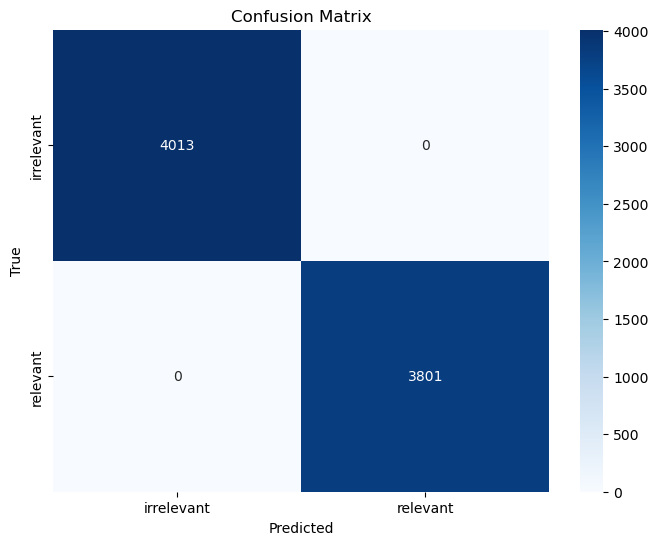

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_np, y_pred_np)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()